<a href="https://colab.research.google.com/github/nadiarvi/my-CNN/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **2023 CS376 Assignment #4: Image Classification with Convolutional Neural Networks (CNNs)**

In this assignment, you should classify the images in the CIFAR10 dataset into 10 categories using Convolution Neural Networks (CNNs).

- Categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

Build a CNN model and take a look at how well it performns as it classifies images in the CIFAR10 dataset.

Train your own CNN model and evaluate the results.

### **PyTorch Documentation**
- You can refer to the PyTorch documentation for your assignment.
- https://pytorch.org/docs/stable/index.html


## **Preparation: Packages**

In [1]:
# Import the required packages.
import os
import random

import numpy as  np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

# Fix the random seed.
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## **Preparation: Experiment configuration**


In [12]:
# Training & optimization hyper-parameters.
max_epoch = 50
learning_rate = 0.2
batch_size = 512
device = 'cuda'

## **Step 1. Data Pipeline Construction**

In [13]:
data_dir = "./my_data"

transform = transforms.Compose(
    [transforms.ToTensor(),                                                         # Transform the data type of images into Tensor.
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])        # Normalize images.

# Define the dataset and dataloader.
train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# The classes of the CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
output_dim = len(classes)

Files already downloaded and verified
Files already downloaded and verified


## **Step 2. Building Convolutional Neural Networks (CNNs)**

In [14]:
class My_Conv2d(nn.Module):
    def __init__(self, in_feature, n_filter, filter_size, stride, pad):
        super(My_Conv2d, self).__init__()
        """
        - in_feature(int): input feature dimension (in_feature(int))
        - n_filter(int): the number of filters (n_filter(int))
        - filter_size(int): the size of filter
        - stride(int): stride
        - pad(int): number of paddings

        Assume that all filters are square filters.
        Shape: [n_filter x in_feature x filter_size x filter_size]

        """
        # Parameters for CNN.
        self.filter_size = filter_size
        self.in_feature = in_feature
        self.n_filter = n_filter

        # Filter for CNN
        self.filters = nn.Parameter(
            torch.zeros((n_filter, in_feature, filter_size, filter_size), requires_grad = True))
        self.bias = nn.Parameter(torch.zeros((1,n_filter,1,1),  requires_grad = True))
        torch.nn.init.xavier_uniform_(self.filters)

        self.stride = stride
        self.pad = pad

    def forward(self,x):
        # Input size: [n_batch x in_feature x H x W]
        # Output size: [n_batch x n_filter x H' x W']
        new_h = (x.shape[2] - self.filter_size + 2 * self.pad) // self.stride + 1
        new_w = (x.shape[3] - self.filter_size + 2 * self.pad) // self.stride + 1

        # Add the padding
        padded_x = F.pad(x, pad = (self.pad, self.pad, self.pad, self.pad))

        # Precalculate the strided verison of the padded input.
        strided = torch.as_strided(padded_x, (padded_x.shape[0], padded_x.shape[1], new_h, new_w, self.filter_size, self.filter_size), \
                                   (padded_x.shape[1] * padded_x.shape[2] * padded_x.shape[3], padded_x.shape[2]*padded_x.shape[3],  self.stride * padded_x.shape[3], self.stride, padded_x.shape[3], 1))

        # Calculate the CNN result.
        """
        self.filters: [n_filter, C, Filter size, Filter size]
        strided: [B, C, H, W, Filter size, Filter size]
        """
        result_x = torch.tensordot(self.filters, strided, dims=([1,2,3],[1,4,5])).transpose(0,1) + self.bias
        return result_x

## **Step 3. Building a CNN model based on My_Conv2d**

In [15]:
class MyOwnClassifier(nn.Module):
    def __init__(self):
        super(MyOwnClassifier, self).__init__()
        self.conv1 = My_Conv2d(3, 64, 3, 1, 1)
        self.maxpool1 = nn.MaxPool2d(2, stride = 2)
        self.dropout1 = nn.Dropout()
        self.conv2 = My_Conv2d(64, 128, 3, 1, 1)
        self.maxpool2 = nn.MaxPool2d(2, stride = 2)
        self.dropout2 = nn.Dropout()
        self.conv3 = My_Conv2d(128, 256, 3, 1, 1)
        self.maxpool3 = nn.MaxPool2d(2, stride = 2)
        self.dropout3 = nn.Dropout()
        self.fcn1 = nn.Linear(256*4*4, 256)
        self.dropout4 = nn.Dropout()
        self.fcn2 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()


    def forward(self, x):
        x1 = self.dropout1(self.maxpool1(self.relu(self.conv1(x))))
        x2 = self.dropout2(self.maxpool2(self.relu(self.conv2(x1))))
        x3 = self.dropout3(self.maxpool3(self.relu(self.conv3(x2))))
        x4 = self.dropout4(self.relu(self.fcn1(torch.flatten(x3, start_dim = 1))))
        output = self.fcn2(x4)
        return output

## **Step 4. Initialize the network and optimizer**

In [16]:
my_classifier = MyOwnClassifier()
my_classifier = my_classifier.to(device)

# Print the architecture of CNN
print(my_classifier)

optimizer = optim.SGD(my_classifier.parameters(), lr=learning_rate)

MyOwnClassifier(
  (conv1): My_Conv2d()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): My_Conv2d()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): My_Conv2d()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fcn1): Linear(in_features=4096, out_features=256, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fcn2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


## **Step 5. Train the network**

In [17]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(max_epoch):
    my_classifier.train()
    epoch_loss = 0
    epoch_acc = 0
    n_train = 0
    for inputs, labels in train_dataloader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = my_classifier(inputs)

        # Calculate loss
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save loss and accuracy for visualization
        epoch_loss += loss.item()*inputs.size(0)
        epoch_acc += (logits.argmax(dim=1) == labels).float().sum().item()
        n_train += inputs.size(0)

    # Save losses and accuracies for visualization
    epoch_loss /= n_train
    epoch_acc /= n_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)


    # Test phase
    n_test = 0.
    test_loss = 0.
    test_acc = 0.

    my_classifier.eval()
    for test_inputs, test_labels in test_dataloader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        logits = my_classifier(test_inputs)
        tmp_loss = F.cross_entropy(logits, test_labels, reduction='sum')

        # Save loss and accuracy for visualization
        test_loss += tmp_loss.item()
        test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
        n_test += test_inputs.size(0)

    test_loss /= n_test
    test_acc /= n_test
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print('[epoch:{}] train loss : {:.4f} train accuracy : {:.4f} test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch+1, epoch_loss, epoch_acc, test_loss, test_acc))

[epoch:1] train loss : 2.0848 train accuracy : 0.2313 test_loss : 2.0338 test accuracy : 0.2883
[epoch:2] train loss : 1.8093 train accuracy : 0.3461 test_loss : 1.6858 test accuracy : 0.4305
[epoch:3] train loss : 1.6719 train accuracy : 0.3982 test_loss : 1.5467 test accuracy : 0.4829
[epoch:4] train loss : 1.5417 train accuracy : 0.4468 test_loss : 1.4610 test accuracy : 0.5019
[epoch:5] train loss : 1.4611 train accuracy : 0.4734 test_loss : 1.3545 test accuracy : 0.5410
[epoch:6] train loss : 1.3965 train accuracy : 0.4973 test_loss : 1.2762 test accuracy : 0.5499
[epoch:7] train loss : 1.3426 train accuracy : 0.5209 test_loss : 1.3268 test accuracy : 0.5588
[epoch:8] train loss : 1.2919 train accuracy : 0.5388 test_loss : 1.1968 test accuracy : 0.6026
[epoch:9] train loss : 1.2454 train accuracy : 0.5585 test_loss : 1.1587 test accuracy : 0.6048
[epoch:10] train loss : 1.2111 train accuracy : 0.5697 test_loss : 1.1277 test accuracy : 0.6100
[epoch:11] train loss : 1.1656 train ac

## **Step 6. Visualize the loss and accuracy**

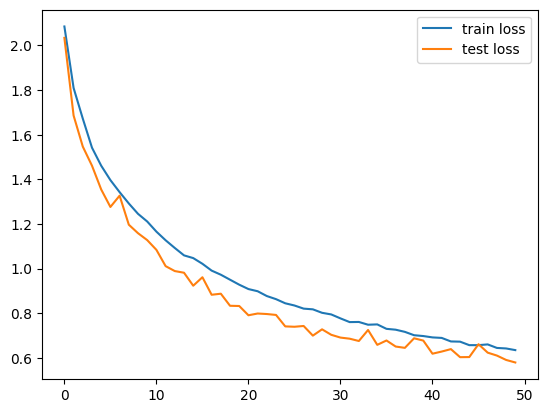

In [18]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

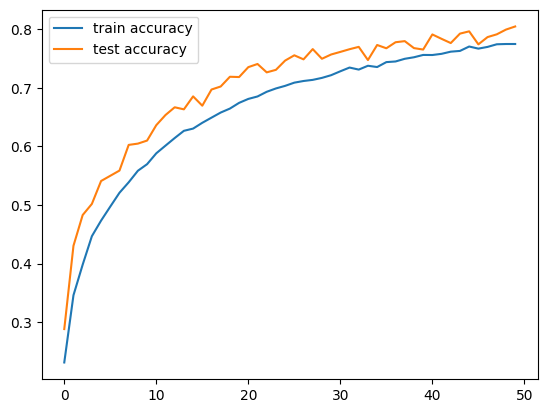

In [19]:
plt.clf()
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='test accuracy')
plt.legend()
plt.show()

label : dog
prediction : dog


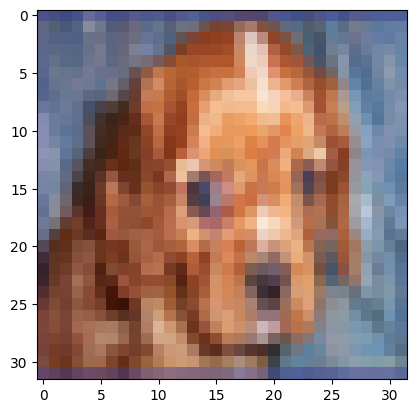

In [20]:
my_classifier.eval()

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)
test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

def imshow(img):
    img[0] = img[0] * 0.247 + 0.4914
    img[1] = img[1] * 0.243 + 0.4822
    img[2] = img[2] * 0.261 + 0.4465
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Show images
imshow(torchvision.utils.make_grid(test_input))